

Olá estudante!

Me chamo Rafael Meirelles e irei revisar o seu projeto hoje e em eventuais futuras submissões até que ele cumpra todos os requisitos para o aceite.
Conte comigo nessa jornada e não se preocupe se precisar ajustar alguns detalhes, é parte do processo e fundamental para que você exercite os conceitos que vem aprendendo e assim melhore a qualidade dos seus códigos e análises.

**Peço que mantenha e não altereos comentários que eu fizer por aqui para que possamos nos localizar posteriormente, ok?**

Mais uma coisa, vamos utilizar um código de cores para você entender os meus feedbacks no seu notebook. Funciona assim:


<div class="alert alert-danger">
<strong>Vermelho</strong>

Erro que precisa ser consertado, caso contrário, seu projeto não pode ser aceito

</div>

<div class="alert alert-warning">
<strong>Amarelo</strong>

Alerta de um erro não crítco, mas que pode ser corrigido para melhoria geral no seu código/análise

</div>

<div class="alert alert-success">
<strong>Verde</strong>

Elogios
</div>

<div class="alert alert-info">
<strong>Comentário do estudante</strong>

Use uma caixa azul como essa para eventuais comentários que você gostaria de fazer para mim.
</div>




# Instrução do Projeto

A Film Junky Union, uma nova comunidade para entusiastas de filmes clássicos, está desenvolvendo um sistema para filtrar e categorizar resenhas de filmes. O objetivo é treinar um modelo para detectar automaticamente resenhas negativas. Você usará um conjunto de dados de resenhas de filmes do IMDB com rotulagem de polaridade para criar um modelo para classificar resenhas como positivas e negativas. Ele precisará ter um valor F1 de pelo menos 0,85.

## Inicialização

In [52]:
import math

import numpy as np
import pandas as pd
import re

from nltk.corpus import stopwords as nltk_stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [53]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# a próxima linha fornece gráficos de melhor qualidade em telas HiDPI
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [54]:
# isso é para usar progress_apply, leia mais em https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Carregar Dados

In [55]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})
print(df_reviews.head(5))
df_reviews.describe()

      tconst title_type primary_title original_title  start_year end_year  \
0  tt0068152      movie             $              $        1971       \N   
1  tt0068152      movie             $              $        1971       \N   
2  tt0313150      short          '15'           '15'        2002       \N   
3  tt0313150      short          '15'           '15'        2002       \N   
4  tt0313150      short          '15'           '15'        2002       \N   

  runtime_minutes  is_adult              genres  average_rating  votes  \
0             121         0  Comedy,Crime,Drama             6.3   2218   
1             121         0  Comedy,Crime,Drama             6.3   2218   
2              25         0  Comedy,Drama,Short             6.3    184   
3              25         0  Comedy,Drama,Short             6.3    184   
4              25         0  Comedy,Drama,Short             6.3    184   

                                              review  rating   sp  pos  \
0  The pakage impl

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,2.556292e+04,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,8.367004e+04,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


In [56]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [57]:
df_reviews=df_reviews.drop_duplicates(subset=set(df_reviews).remove('tconst'))
df_reviews=df_reviews.dropna()
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47329 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47329 non-null  object 
 1   title_type       47329 non-null  object 
 2   primary_title    47329 non-null  object 
 3   original_title   47329 non-null  object 
 4   start_year       47329 non-null  int64  
 5   end_year         47329 non-null  object 
 6   runtime_minutes  47329 non-null  object 
 7   is_adult         47329 non-null  int64  
 8   genres           47329 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47329 non-null  object 
 12  rating           47329 non-null  int64  
 13  sp               47329 non-null  object 
 14  pos              47329 non-null  int64  
 15  ds_part          47329 non-null  object 
 16  idx              47329 non-null  int64  
dtypes: Int64(1),

<div class="alert alert-danger">
<strong>Comentário do revisor v1</strong>

Lembre-se de buscar por duplicados.
    
Verificamos a presença de poucos valores missings... De qualquer forma precisamos enderecá-los de alguma forma.
</div>


## AED

Vamos verificar o número de filmes e resenhas ao longo dos anos.

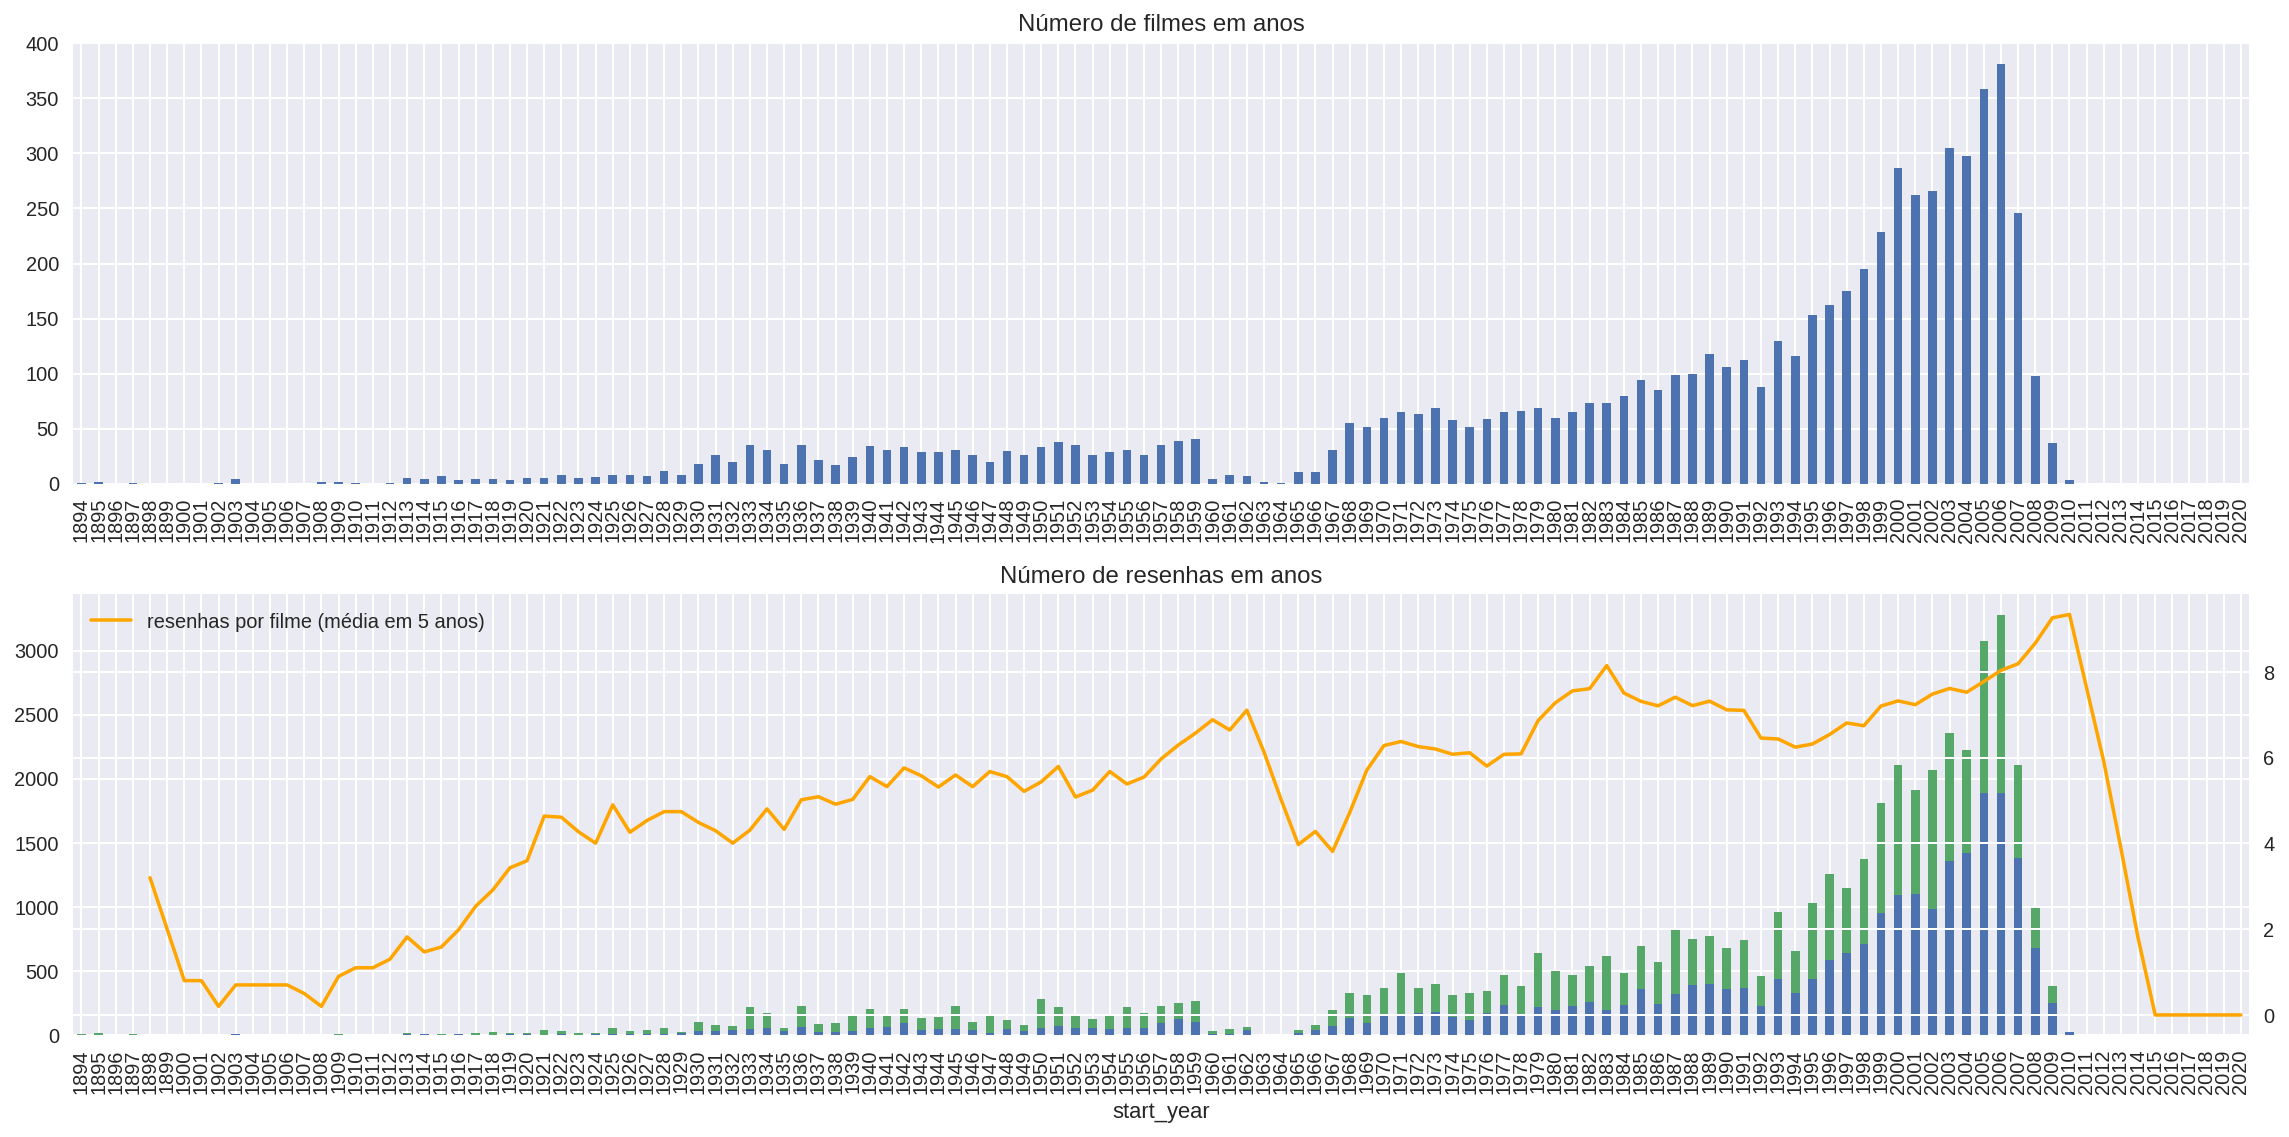

In [58]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de filmes em anos')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='resenhas por filme (média em 5 anos)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de resenhas em anos')

fig.tight_layout()

Vamos verificar a distribuição do número de resenhas por filme com a contagem exata e o EDK (Estimativa de densidade kernel - só para saber como pode diferir da contagem exata)

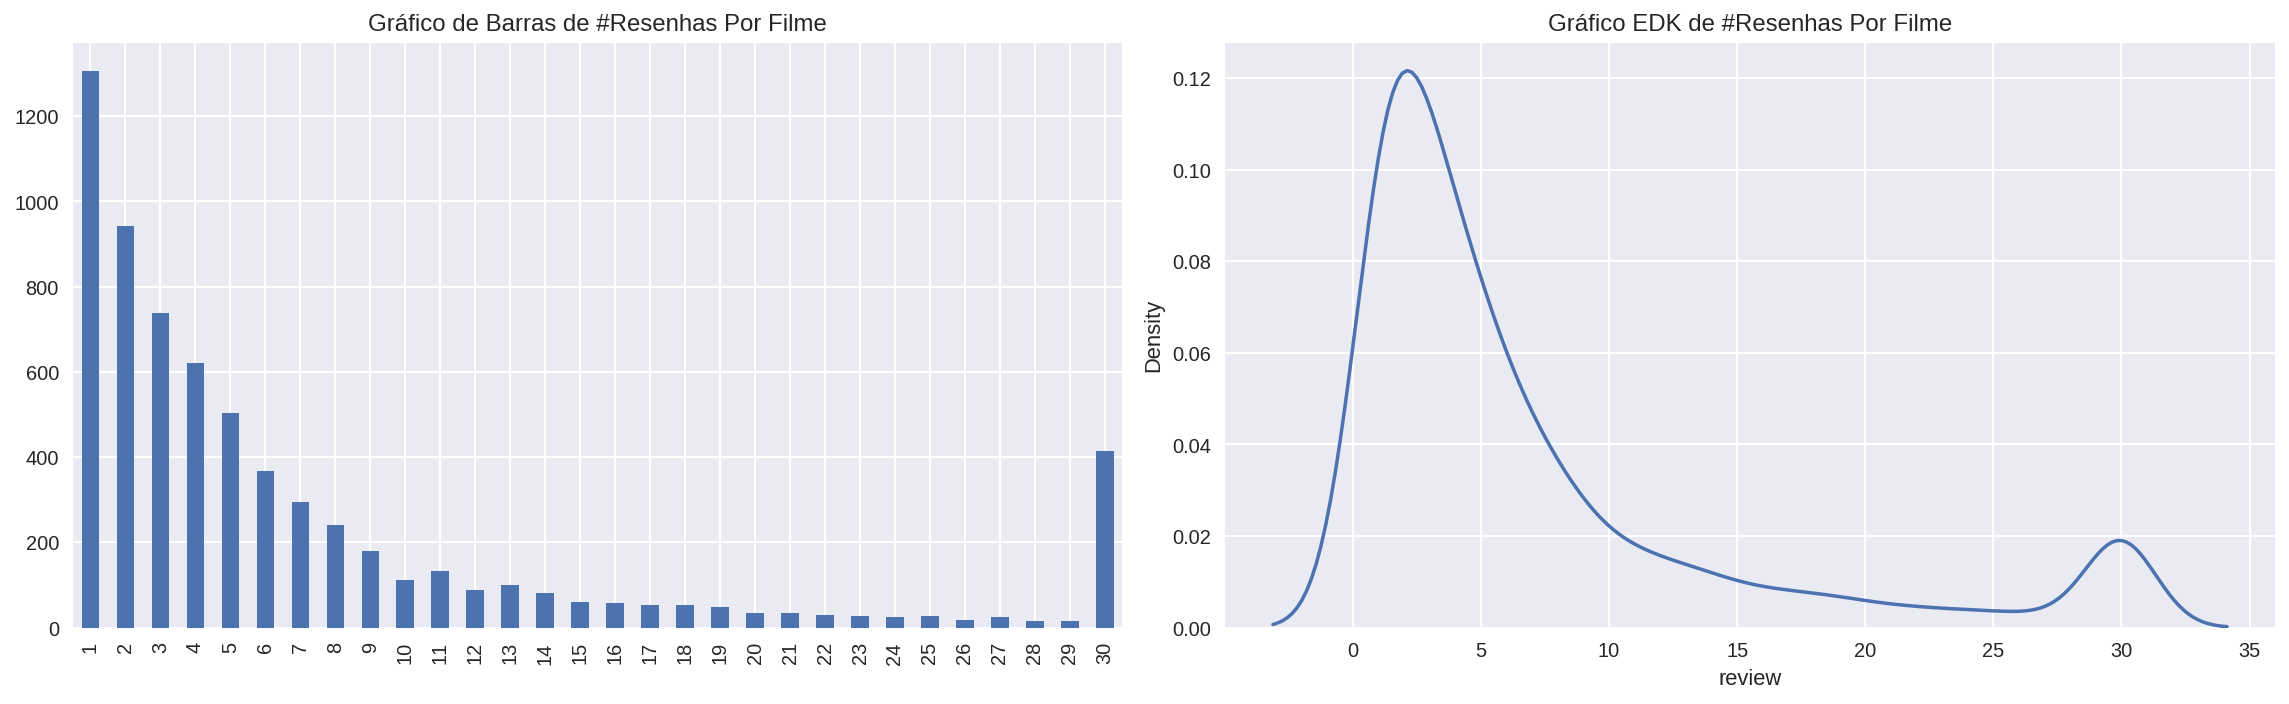

In [59]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de Barras de #Resenhas Por Filme')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico EDK de #Resenhas Por Filme')

fig.tight_layout()

Alguns filmes tem muito mais resenhas que outros, provavelmente por serem mais populares, mas alem de desequilibrar a classe, isso pode levar a uma limitação do vocabulario do modelo

In [60]:
df_reviews['pos'].value_counts()

0    23715
1    23614
Name: pos, dtype: int64

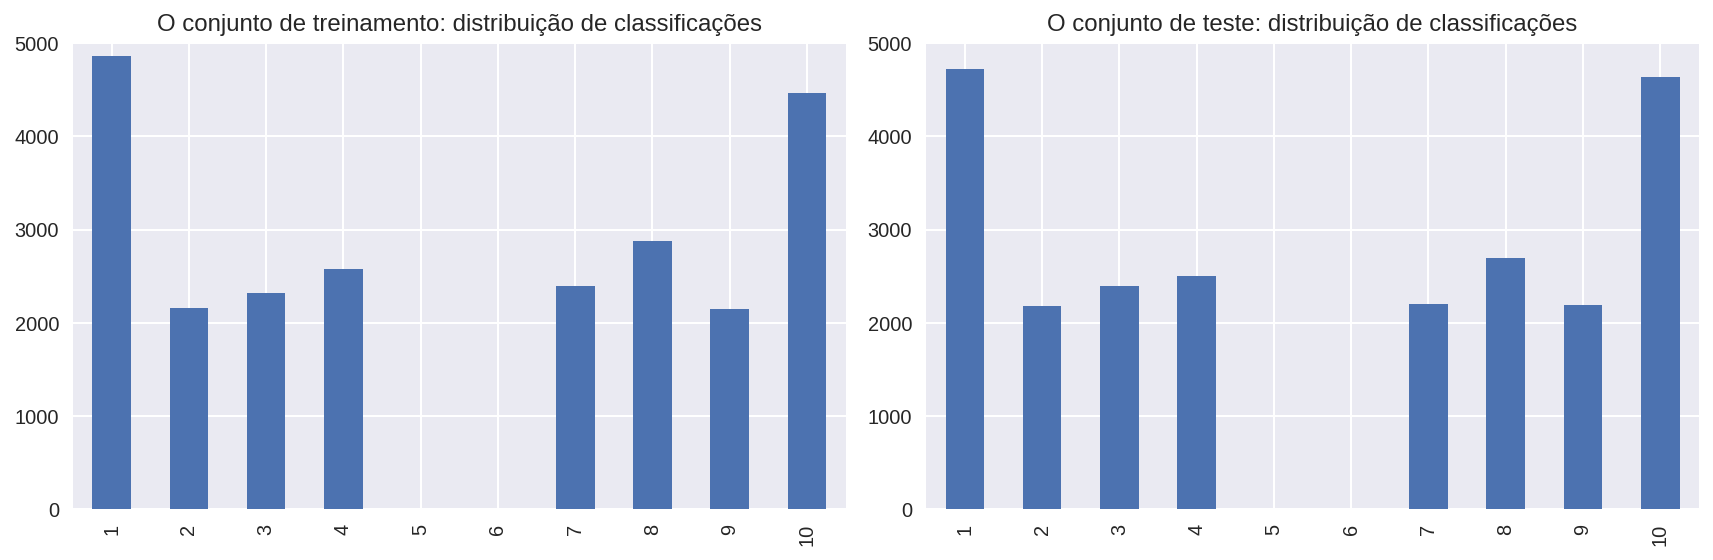

In [61]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('O conjunto de treinamento: distribuição de classificações')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('O conjunto de teste: distribuição de classificações')

fig.tight_layout()

Distribuição de resenhas negativas e positivas ao longo dos anos para duas partes do conjunto de dados

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


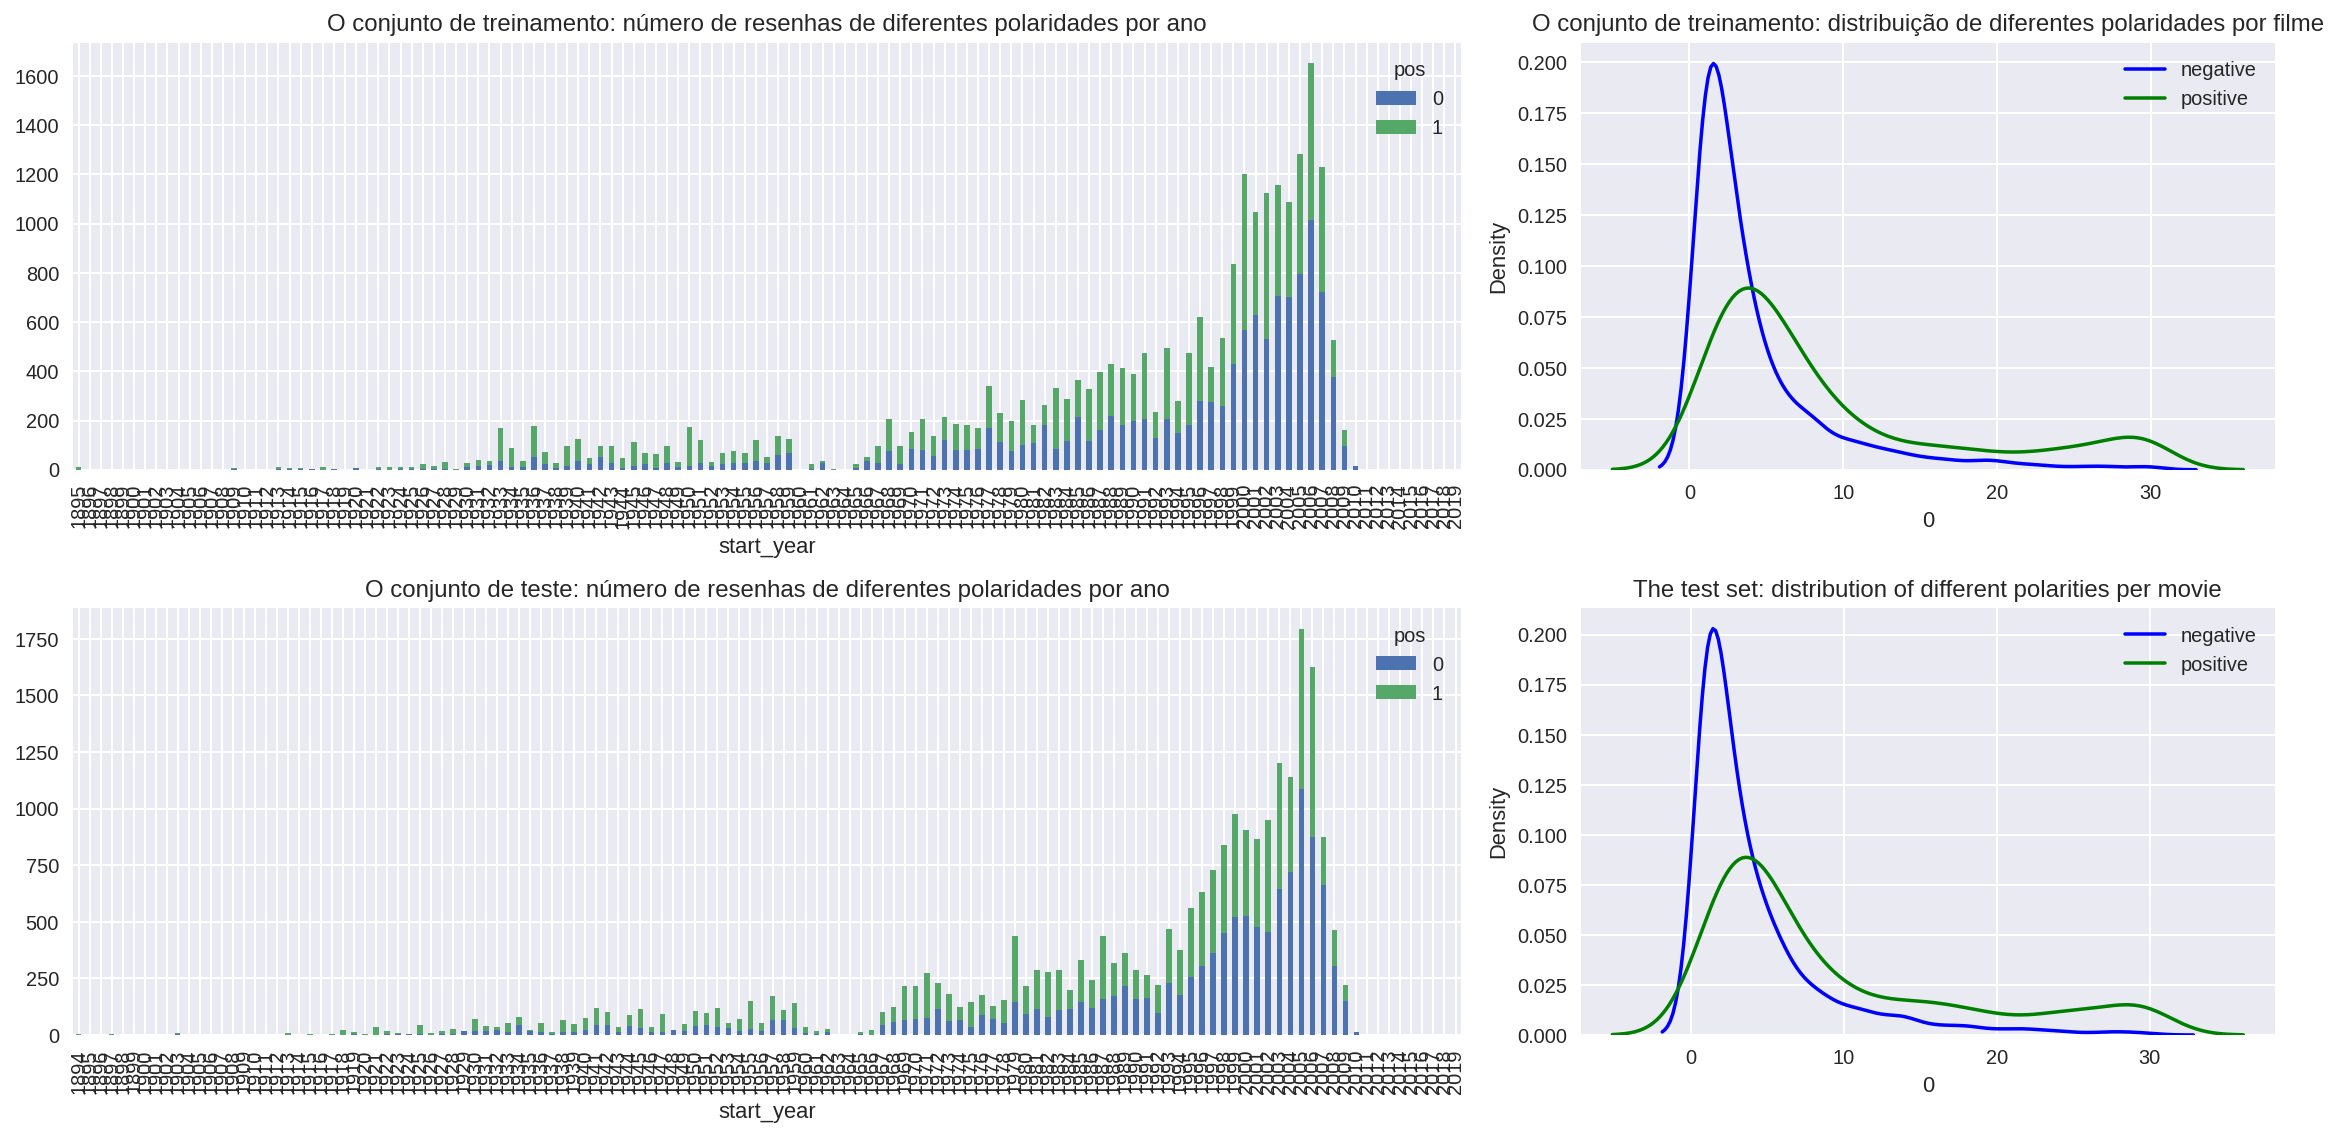

In [62]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('O conjunto de treinamento: número de resenhas de diferentes polaridades por ano')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('O conjunto de treinamento: distribuição de diferentes polaridades por filme')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('O conjunto de teste: número de resenhas de diferentes polaridades por ano')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

As classes estão bem desequilibradas, com a quantidade de 1 ou positivos sendo o dobro de negativos ou 0

<div class="alert alert-success">
<strong>Comentário do revisor v1</strong>

Bom trabalho com o diagnóstico
</div>


## Procedimento de Avaliação

Compondo uma rotina de avaliação que pode ser utilizada para todos os modelos deste projeto

In [63]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # Curva de precisão-revocação
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # definindo cruzamentos para alguns limiares
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # Curva de precisão-revocação
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # definindo cruzamentos para alguns limiares
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Acurácia', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalização

Assumimos que todos os modelos abaixo aceitam textos em letras minúsculas e sem dígitos, sinais de pontuação, etc.

In [64]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

lemmatizer  = WordNetLemmatizer()

def lematizer(text):
    tokens = word_tokenize(text.lower())

    lemmas = [lemmatizer.lemmatize(token) for token in tokens] 
    
    return " ".join(lemmas)
texts=df_reviews['review']
lematized=[]
for text in tqdm(texts):
    lematized.append(lematizer(text))
df_reviews['review_norm'] = lematized

  0%|          | 0/47329 [00:00<?, ?it/s]

## Treinar / Testar Conjunto

Felizmente, todo o conjunto de dados já está dividido em partes de treinamento/teste. A opção correspondente é 'ds_part'.

In [65]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23533, 18)


## Trabalhando com modelos

### Modelo 0 - Constante

In [66]:
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

In [67]:
stop_words=list(nltk_stopwords.words('english'))
model=DummyClassifier(strategy="most_frequent")

In [68]:
corpus_train=df_reviews_train['review_norm']
corpus_test=df_reviews_test['review_norm']

vect=TfidfVectorizer(stop_words=stop_words)
train_features_1= vect.fit_transform(corpus_train)
test_features_1=vect.transform(corpus_test)

model.fit(train_features_1,train_target)
print(metrics.accuracy_score(test_target, model.predict(test_features_1)))

0.5015510134704457


          train  test
Acurácia    NaN   NaN
F1          NaN   NaN
APS         0.5   0.5
ROC AUC     0.5   0.5


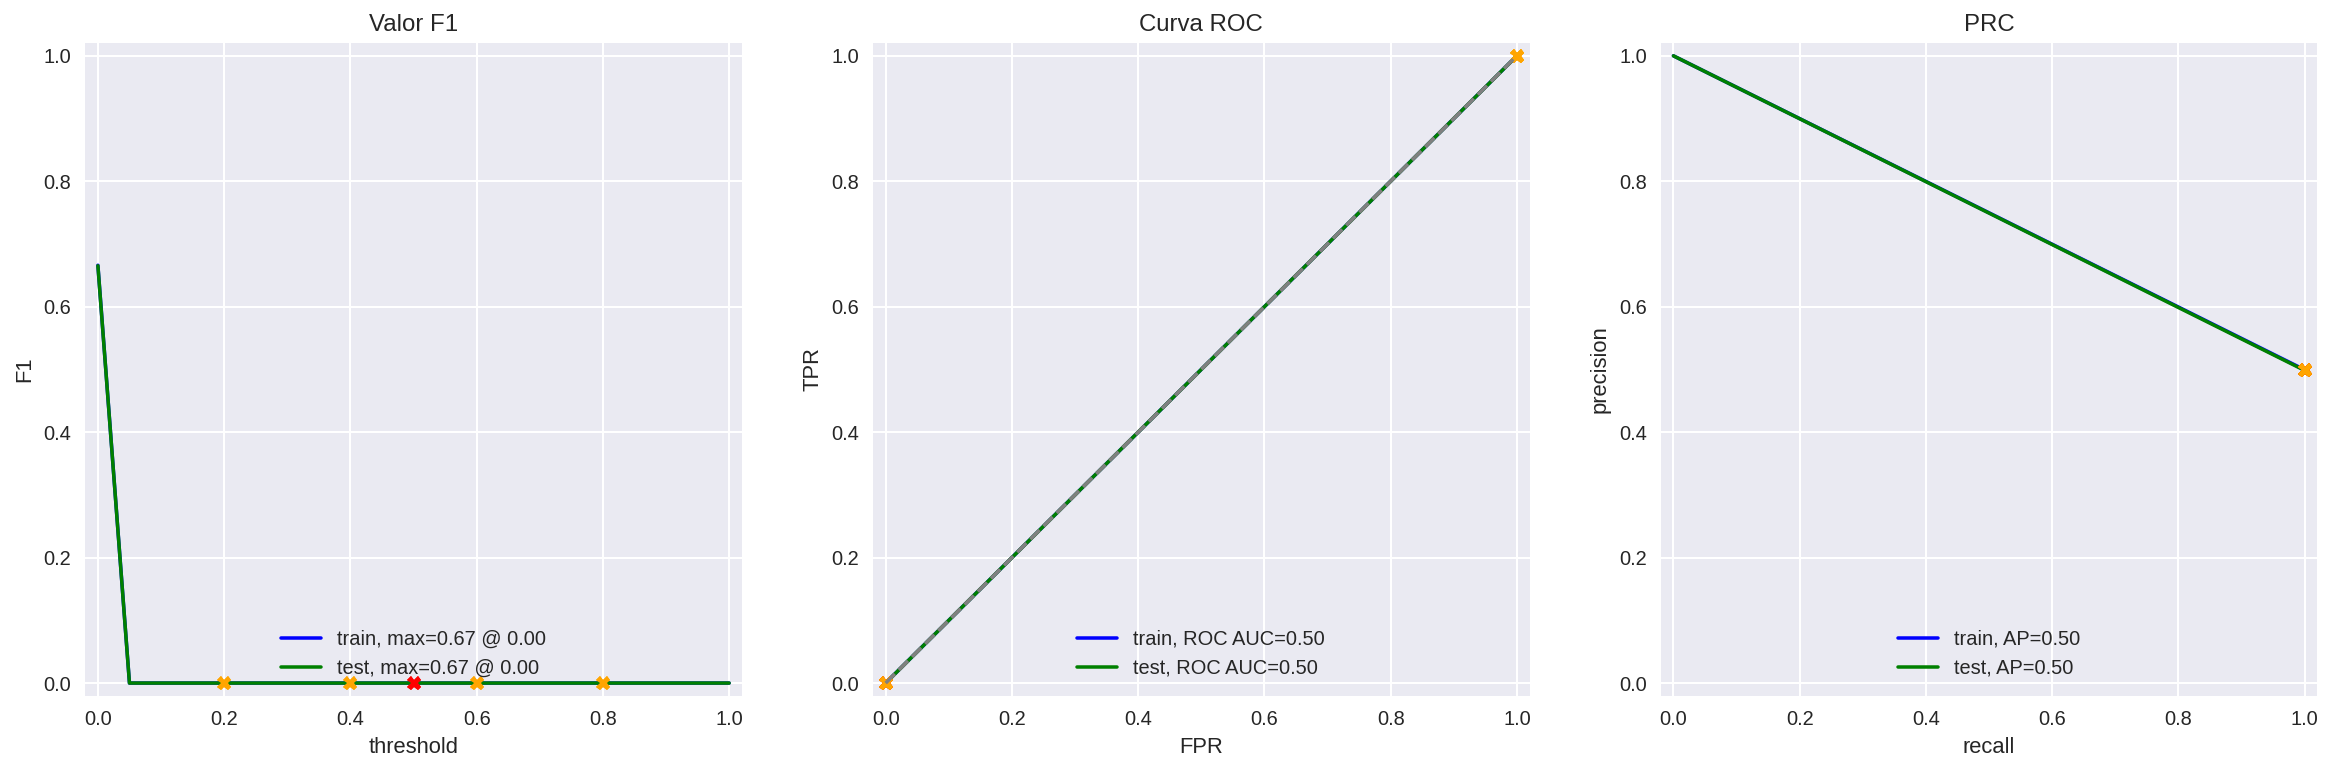

In [69]:
evaluate_model(model, train_features_1, train_target, test_features_1, test_target)

### Modelo 1 - NLTK, TF-IDF e Regressão Linear

TF-IDF

In [70]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [71]:
corpus_train=df_reviews_train['review_norm']
corpus_test=df_reviews_test['review_norm']

vect=TfidfVectorizer(stop_words=stop_words)
train_features_1= vect.fit_transform(corpus_train)
test_features_1=vect.transform(corpus_test)

model_1=LogisticRegression()
model_1.fit(train_features_1,train_target)
print(metrics.accuracy_score(test_target, model_1.predict(test_features_1)))

0.8799558067394723


          train  test
Acurácia    NaN   NaN
F1          NaN   NaN
APS        0.98  0.95
ROC AUC    0.98  0.95


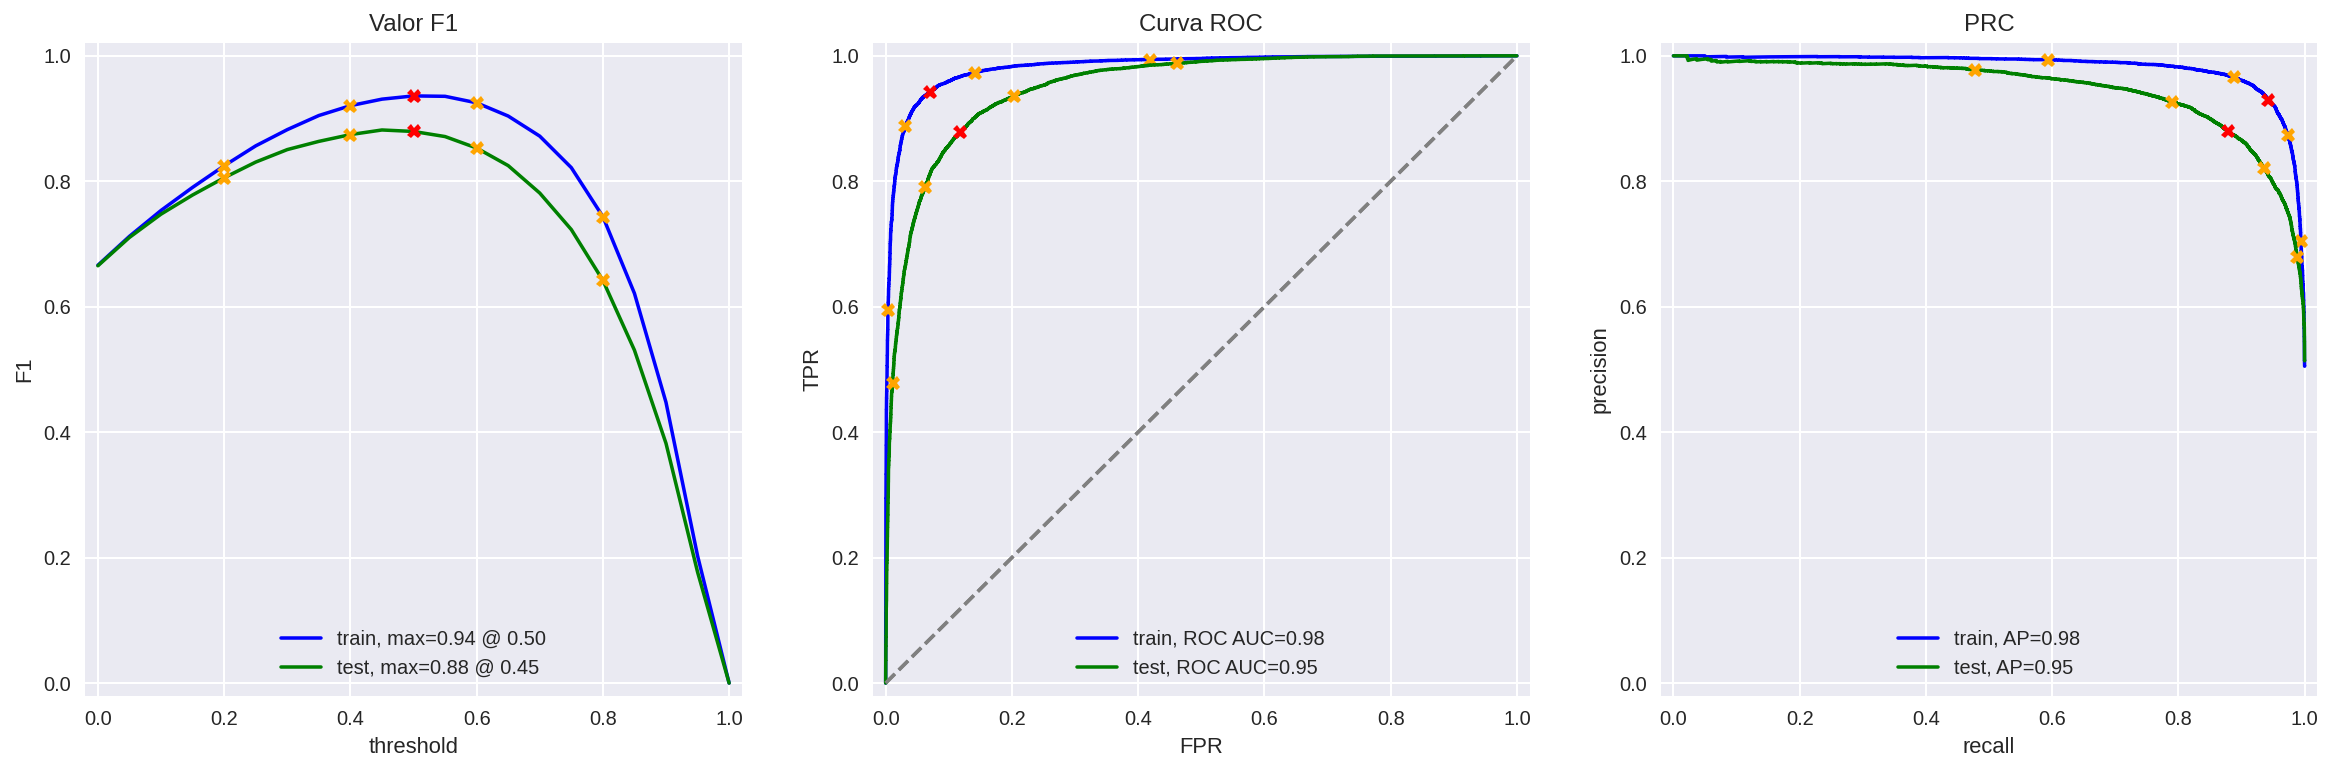

In [72]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

### Modelo 3 - spaCy, TF-IDF e Regressão Linear

In [73]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [74]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)
corpus=df_reviews['review_norm']
lemm=[]
for text in tqdm(corpus):
    lemm.append(text_preprocessing_3(text))
df_reviews['review_lemm']=lemm
    
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

  0%|          | 0/47329 [00:00<?, ?it/s]

In [75]:
corpus_train=df_reviews_train['review_lemm']
corpus_test=df_reviews_test['review_lemm']


vect=TfidfVectorizer(stop_words=stop_words)
train_features_2= vect.fit_transform(corpus_train)
test_features_2=vect.transform(corpus_test)

model_2=LogisticRegression()
model_2.fit(train_features_2,train_target)
print(metrics.accuracy_score(test_target, model_2.predict(test_features_2)))

0.8797008456210428


          train  test
Acurácia    NaN   NaN
F1          NaN   NaN
APS        0.98  0.95
ROC AUC    0.98  0.95


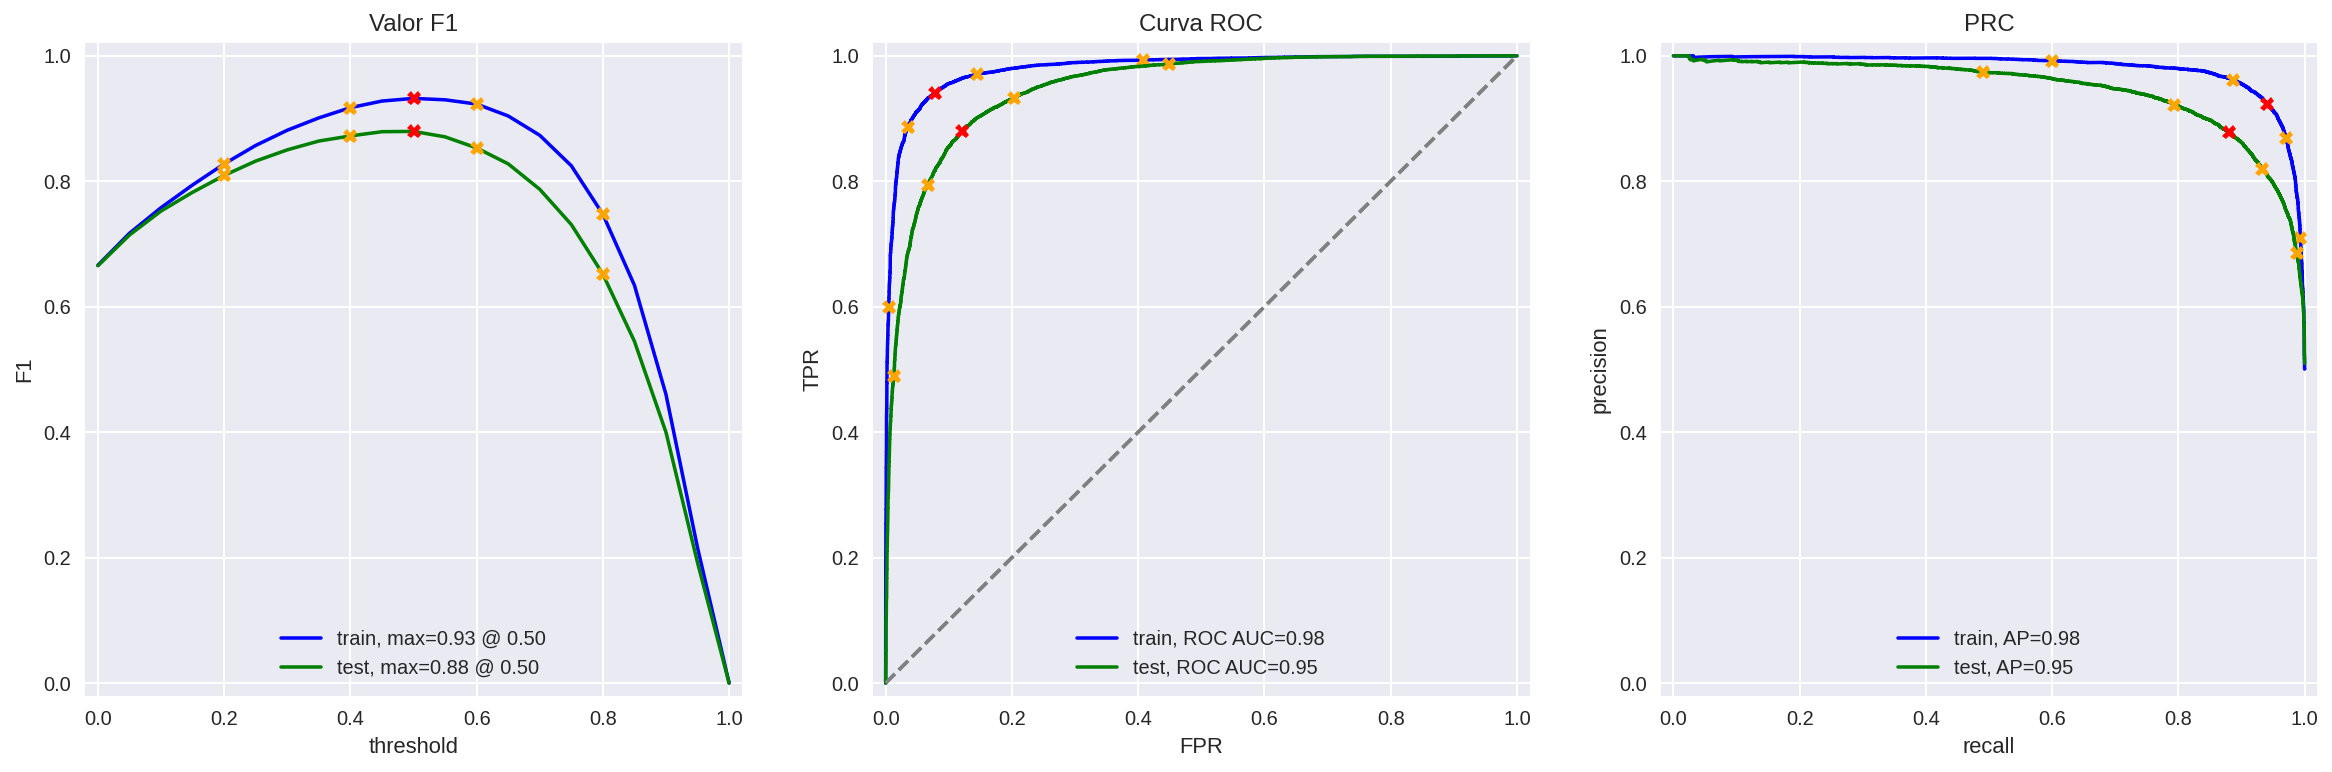

In [76]:
evaluate_model(model_2, train_features_2, train_target, test_features_2, test_target)

### Modelo 4 - SpaCy, TF-IDF e LGBMClassifier

In [77]:
from lightgbm import LGBMClassifier

In [78]:
corpus_train=df_reviews_train['review_lemm']
corpus_test=df_reviews_test['review_lemm']

vect=TfidfVectorizer(stop_words=stop_words)
train_features_3= vect.fit_transform(corpus_train)
test_features_3=vect.transform(corpus_test)

model_3= LGBMClassifier(random_seed=12345)
model_3.fit(train_features_3,train_target)
print(metrics.accuracy_score(test_target, model_3.predict(test_features_3)))

0.8584115922321846


          train  test
Acurácia    NaN   NaN
F1          NaN   NaN
APS        0.97  0.93
ROC AUC    0.97  0.94


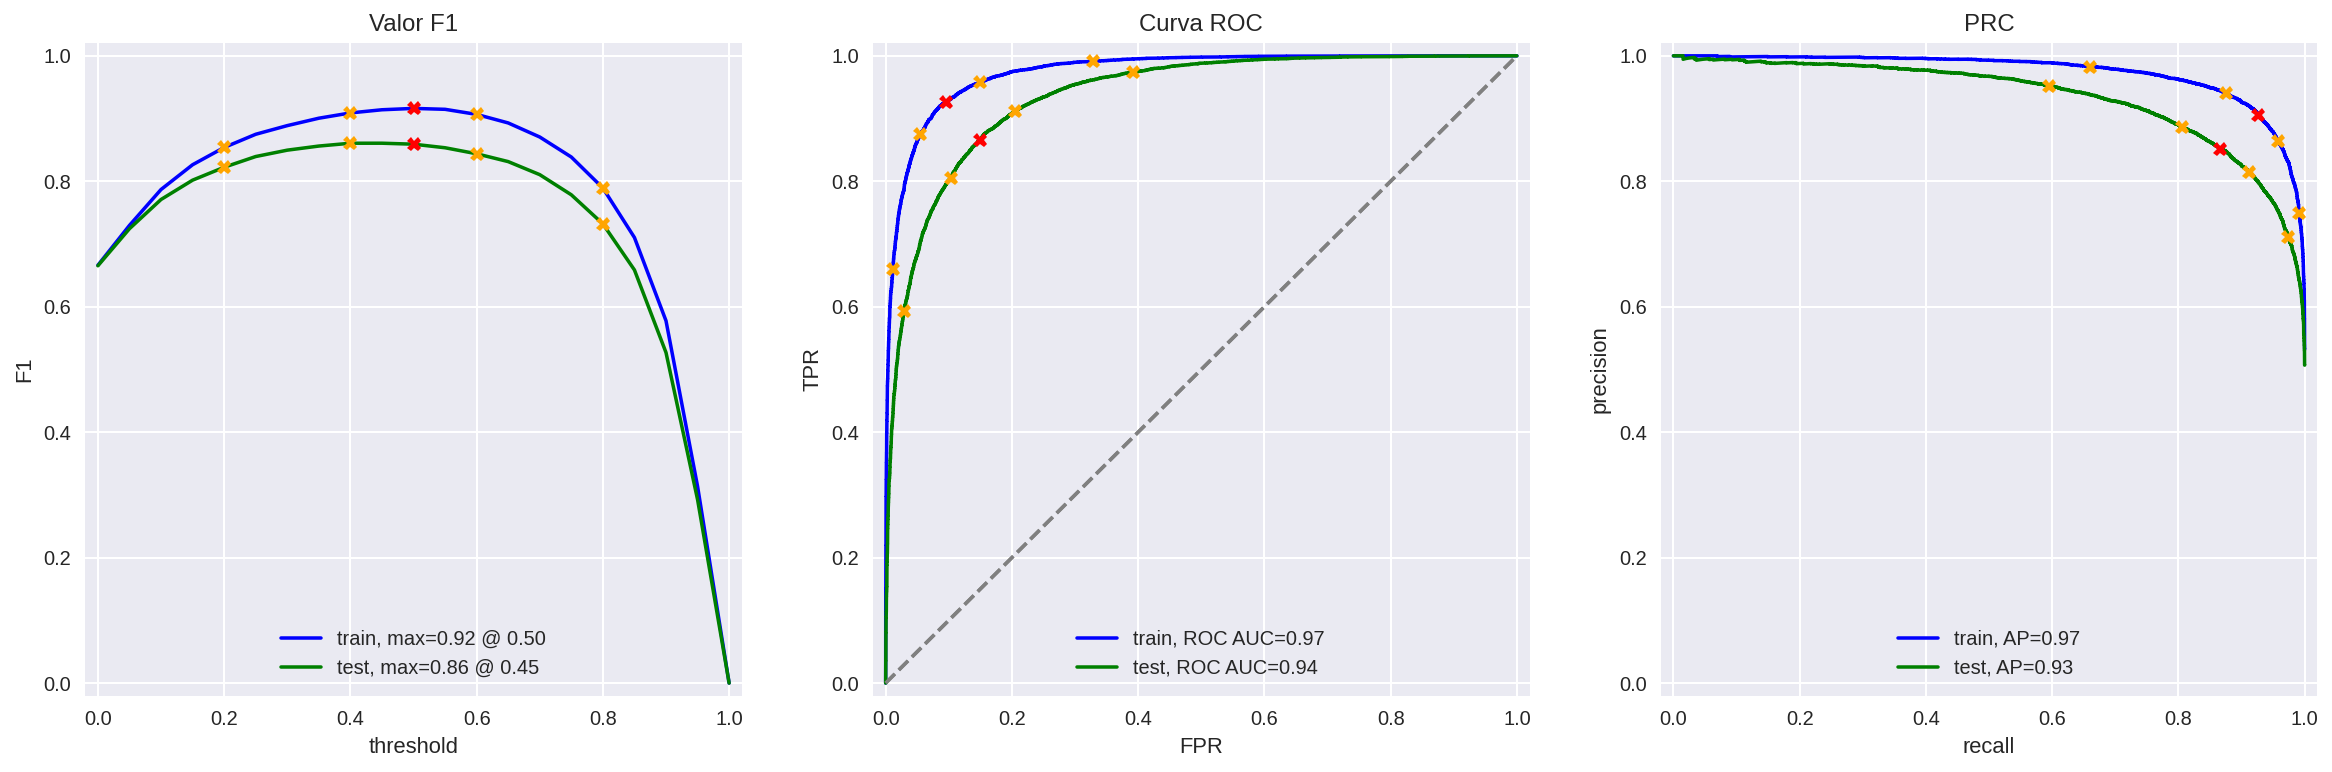

In [79]:
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

###  Modelo 9 - BERT

In [80]:
import torch
import transformers

In [81]:
# tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
# config = transformers.BertConfig.from_pretrained('bert-base-uncased')
# model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [82]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    # texto para IDs de tokens preenchidos com suas máscaras de atenção
    
    # <coloque seu código aqui para criar ids_list e attention_mask_list>
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Usando o dispositivo {device}.')
    
    # recebendo incorporações em lotes

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        # <coloque seu código aqui para criar attention_mask_batch
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [83]:
# Atenção! A execução do BERT para milhares de textos pode levar muito tempo na CPU, pelo menos várias horas
# train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')

In [84]:
# print(df_reviews_train['review_norm'].shape)
# print(train_features_9.shape)
# print(train_target.shape)

In [85]:
# se você tiver as incorporações, é aconselhável salvá-las para tê-las prontas se 
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# e carregar...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

<div class="alert alert-success">
<strong>Comentário do revisor v1</strong>

Bom trabalho com o treinamento dos modelos!
</div>


## Minhas Resenhas

In [86]:
# sinta-se à vontade para remover completamente essas resenhas e experimentar seus modelos nas suas próprias resenhas, as abaixo são apenas exemplos

my_reviews = pd.DataFrame([
    'Death note live action é um ataque a industria cinematografica tão ruim que nunca o chamaria de filme, mas de uma atrocidade',
    'Bem, eu fiquei entediado quando os macacos começaram a gritar no obelisko gigante e dormi no meio do filme.',
    'Eu fiquei realmente fascinado com o filme',    
    'Os atores pareciam muito velhos e desinteressados, e mesmo assim foram pagos para participar do filme. Que roubo de dinheiro sem vergonha.',
    'Eu não esperava que a nova versão fosse tão boa! Os escritores realmente se importaram com o material original',
    'O filme tem seus prós e contras, mas eu sinto que em geral é um filme decente. Eu posso me imaginar indo assistir novamente.',
    'Que tentativa podre de comédia. Nem uma única piada cai, todo mundo age de forma irritante e barulhenta, nem crianças não vão gostar disso!',
    'Lançar na Netflix foi uma jogada corajosa e eu realmente aprecio ser capaz de assistir episódio após episódio, deste emocionante e inteligente novo drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review']

my_reviews

,review,review_norm
0,Death note live action é um ataque a industria...,Death note live action é um ataque a industria...
1,"Bem, eu fiquei entediado quando os macacos com...","Bem, eu fiquei entediado quando os macacos com..."
2,Eu fiquei realmente fascinado com o filme,Eu fiquei realmente fascinado com o filme
3,Os atores pareciam muito velhos e desinteressa...,Os atores pareciam muito velhos e desinteressa...
4,Eu não esperava que a nova versão fosse tão bo...,Eu não esperava que a nova versão fosse tão bo...
5,"O filme tem seus prós e contras, mas eu sinto ...","O filme tem seus prós e contras, mas eu sinto ..."
6,Que tentativa podre de comédia. Nem uma única ...,Que tentativa podre de comédia. Nem uma única ...
7,Lançar na Netflix foi uma jogada corajosa e eu...,Lançar na Netflix foi uma jogada corajosa e eu...


### Modelo 2

In [87]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(vect.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.55:  Death note live action é um ataque a industria cinematografica tão ruim que nunca o chamaria de film
0.48:  Bem, eu fiquei entediado quando os macacos começaram a gritar no obelisko gigante e dormi no meio do
0.59:  Eu fiquei realmente fascinado com o filme
0.49:  Os atores pareciam muito velhos e desinteressados, e mesmo assim foram pagos para participar do film
0.44:  Eu não esperava que a nova versão fosse tão boa! Os escritores realmente se importaram com o materia
0.49:  O filme tem seus prós e contras, mas eu sinto que em geral é um filme decente. Eu posso me imaginar 
0.57:  Que tentativa podre de comédia. Nem uma única piada cai, todo mundo age de forma irritante e barulhe
0.48:  Lançar na Netflix foi uma jogada corajosa e eu realmente aprecio ser capaz de assistir episódio após


### Modelo 3

In [88]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(vect.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.65:  Death note live action é um ataque a industria cinematografica tão ruim que nunca o chamaria de film
0.62:  Bem, eu fiquei entediado quando os macacos começaram a gritar no obelisko gigante e dormi no meio do
0.64:  Eu fiquei realmente fascinado com o filme
0.62:  Os atores pareciam muito velhos e desinteressados, e mesmo assim foram pagos para participar do film
0.49:  Eu não esperava que a nova versão fosse tão boa! Os escritores realmente se importaram com o materia
0.62:  O filme tem seus prós e contras, mas eu sinto que em geral é um filme decente. Eu posso me imaginar 
0.65:  Que tentativa podre de comédia. Nem uma única piada cai, todo mundo age de forma irritante e barulhe
0.62:  Lançar na Netflix foi uma jogada corajosa e eu realmente aprecio ser capaz de assistir episódio após


O motivo da diferença dos resultados nas resenhas para o banco de dados provavelmente vem do fato de estarem em linguagems diferentes, assim o "dicionario" em que o modelo foi treinado não inclui as palavras em portugues

Parece que o modelo LightLGBM tem a tendencia a apresentar resultados mais positivos comparado a regressão logistica

<div class="alert alert-danger">
<strong>Comentário do revisor v1</strong>

Seria positivo passar pelos insights que obteve a partir da avaliação das resenhas acima.
</div>


## Conclusões

O motivo da diferença dos resultados nas resenhas para o banco de dados provavelmente vem do fato de estarem em linguagems diferentes, assim o "dicionario" em que o modelo foi treinado não inclui as palavras em portugues

Alguns filmes tem muito mais resenhas que outros, provavelmente por serem mais populares, mas alem de desequilibrar a classe, isso pode levar a uma limitação do vocabulario do modelo

E alguns anos tambem tem muitos mais filmes que outros, com uma faixa de 

As classes estão bem desequilibradas, com a quantidade de 1 ou positivos sendo o dobro de negativos ou 0, talvez seja interessante aplicar tecnicas para equilibrar mais as classes

O melhor modelo foi a regressão logistica sem o processamento de texto do spacy, tendo a melhor precisão de todos os modelos e a melhor velocidade, com 3 minutos para processar o texto e baixo tempo de execução, comparado aos 20 minutos de processamento do spacy, e menor tempo de execução em relação ao LGBM.

O pior modelo foi o classificador LGBM,mesmo sendo uma otima biblioteca para outros tipos de classificação, que envolvem dados categoricos por exemplo

<div class="alert alert-success">
<strong>Comentário do revisor v1</strong>

Bom trabalho com o comparativo (embora entendo que caberiam mais detalhes por aqui).
</div>


# Checklist

- [x]  O caderno foi aberto
- [x]  Os dados de texto são carregados e pré-processados para vetorização
- [x]  Os dados de texto são transformados em vetores
- [x]  Os modelos são treinados e testados
- [x]  O limiar da métrica foi atingido
- [x]  Todas as células de código estão organizadas na ordem de sua execução
- [x]  Todas as células de código podem ser executadas sem erros
- [x]  Há conclusões 

<div class="alert alert-danger">
<strong>Comentário do revisor v1</strong>

Estamos no caminho certo com essa versão, mas retocar os pontos indicados acima nos fará chegar em um resultado ainda mais incrível.
    
Conte comigo para ajudá-lo (a) em qualquer questão que possa vir a ter! Lembre-se de usar as caixas azuis para se comunicar comigo.
    
Até breve.
</div>
